# Libraries

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset

In [209]:
dataset = pd.read_csv('predictive_maintenance.csv')
x = dataset.iloc[:, 2:-2].values
y_binary = dataset.iloc[:, -2].values
y_multi = dataset.iloc[:, -1].values
print(x)
print(y_binary)
print(y_multi)

[['M' 298.1 308.6 1551 42.8 0]
 ['L' 298.2 308.7 1408 46.3 3]
 ['L' 298.1 308.5 1498 49.4 5]
 ...
 ['M' 299.0 308.6 1645 33.4 22]
 ['H' 299.0 308.7 1408 48.5 25]
 ['M' 299.0 308.7 1500 40.2 30]]
[0 0 0 ... 0 0 0]
['No Failure' 'No Failure' 'No Failure' ... 'No Failure' 'No Failure'
 'No Failure']


# Encoding

### For X

In [210]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x[:, 0] = le.fit_transform(x[:, 0])
print(x)

[[2 298.1 308.6 1551 42.8 0]
 [1 298.2 308.7 1408 46.3 3]
 [1 298.1 308.5 1498 49.4 5]
 ...
 [2 299.0 308.6 1645 33.4 22]
 [0 299.0 308.7 1408 48.5 25]
 [2 299.0 308.7 1500 40.2 30]]


### For y_multi

In [211]:
# Map multi-class labels
custom_mapping = {
    'No Failure': 0,
    'Overstrain Failure': 1,
    'Power Failure': 2,
    'Heat Dissipation Failure': 3,
    'Tool Wear Failure': 4,
    'Random Failures': 5,
}
y_multi_mapped = np.array([custom_mapping[label] for label in y_multi])

# Feature Scaling

In [212]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)
print(x)

[[ 1.33388944 -0.95238944 -0.94735989  0.06818514  0.28219976 -1.69598374]
 [-0.33222278 -0.90239341 -0.879959   -0.72947151  0.63330802 -1.6488517 ]
 [-0.33222278 -0.95238944 -1.01476077 -0.22744984  0.94428963 -1.61743034]
 ...
 [ 1.33388944 -0.50242514 -0.94735989  0.59251888 -0.66077672 -1.35034876]
 [-1.998335   -0.50242514 -0.879959   -0.72947151  0.85400464 -1.30321671]
 [ 1.33388944 -0.50242514 -0.879959   -0.2162938   0.02137647 -1.22466331]]


In [213]:
from collections import Counter

print("Binary Target Distribution:", Counter(y_binary))
print("Multi-class Target Distribution:", Counter(y_multi))

Binary Target Distribution: Counter({0: 9661, 1: 339})
Multi-class Target Distribution: Counter({'No Failure': 9652, 'Heat Dissipation Failure': 112, 'Power Failure': 95, 'Overstrain Failure': 78, 'Tool Wear Failure': 45, 'Random Failures': 18})


# Applying SMOTE for oversampling

In [214]:
from imblearn.over_sampling import SMOTE

# Oversampling binary target
smote_binary = SMOTE(random_state = 42)
x_resampled_binary, y_resampled_binary = smote_binary.fit_resample(x, y_binary)

# Oversampling multi-class target
smote_multi = SMOTE(random_state = 42)
x_resampled_multi, y_resampled_multi = smote_multi.fit_resample(x, y_multi_mapped)

# Splitting the dataset

In [215]:
from sklearn.model_selection import train_test_split

# Split for binary classification
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(
    x_resampled_binary, y_resampled_binary, test_size = 0.25, random_state = 42, stratify = y_resampled_binary
)

# Split for multi-class classification
x_train_multi, x_test_multi, y_train_multi, y_test_multi = train_test_split(
    x_resampled_multi, y_resampled_multi, test_size = 0.25, random_state = 42, stratify = y_resampled_multi
)

In [216]:
print("Binary Target Distribution:", Counter(y_train_binary))
print("Multi-class Target Distribution:", Counter(y_train_multi))

Binary Target Distribution: Counter({1: 7246, 0: 7245})
Multi-class Target Distribution: Counter({1: 7239, 5: 7239, 2: 7239, 4: 7239, 0: 7239, 3: 7239})


# Building and training the models

In [217]:
from catboost import CatBoostClassifier

classifier_1 = CatBoostClassifier(auto_class_weights='Balanced', verbose = 0, random_state = 42)
classifier_1.fit(x_train_binary, y_train_binary)

In [218]:
from xgboost import XGBClassifier

classifier_2 = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_multi)),
    subsample = 0.6,
    reg_lambda = 0.5,
    reg_alpha = 0.1,
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.3,
    gamma = 0.9,
    colsample_bytree = 1.0,
    random_state = 42
)
classifier_2.fit(x_train_multi, y_train_multi)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

# Evaluating the models

### Classifier 1 (Binary Classifier)

In [219]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred_binary = classifier_1.predict(x_test_binary)

# Evaluation
print("Binary Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))
print("Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_binary))

Binary Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2416
           1       0.97      0.99      0.98      2415

    accuracy                           0.98      4831
   macro avg       0.98      0.98      0.98      4831
weighted avg       0.98      0.98      0.98      4831

Confusion Matrix:
[[2350   66]
 [  28 2387]]


#### k-fold cross validation

In [220]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_1, X = x_train_binary, y = y_train_binary, cv = 10, n_jobs = -1)
print("Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f}%".format(accuracies.std()*100))
print(accuracies)

Accuracy: 97.94%
Standard Deviation: 0.34%
[0.98068966 0.97929607 0.98067633 0.98481712 0.97446515 0.98067633
 0.97446515 0.98205659 0.97515528 0.98205659]


### Classifier 2 (Multi-Classifier)

In [221]:
# Predictions
y_pred_multi = classifier_2.predict(x_test_multi)

# Evaluation
print("Multi-Class Classification Report:")
print(classification_report(y_test_multi, y_pred_multi))
print("Confusion Matrix:")
print(confusion_matrix(y_test_multi, y_pred_multi))

Multi-Class Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2413
           1       1.00      1.00      1.00      2413
           2       1.00      1.00      1.00      2413
           3       1.00      1.00      1.00      2413
           4       0.98      1.00      0.99      2413
           5       0.98      1.00      0.99      2413

    accuracy                           0.99     14478
   macro avg       0.99      0.99      0.99     14478
weighted avg       0.99      0.99      0.99     14478

Confusion Matrix:
[[2295   10    6    3   47   52]
 [   0 2413    0    0    0    0]
 [   1    0 2412    0    0    0]
 [   0    0    0 2413    0    0]
 [   0    0    0    0 2413    0]
 [   0    0    0    0    0 2413]]


#### k-fold cross validation

In [222]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_2, X = x_train_multi, y = y_train_multi, cv = 10, n_jobs = -1)
print("Accuracy: {:.2f}%".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f}%".format(accuracies.std()*100))
print(accuracies)

Accuracy: 99.04%
Standard Deviation: 0.16%
[0.98964088 0.98733886 0.98802947 0.99171271 0.99217131 0.99194105
 0.99009901 0.99055952 0.99102003 0.99194105]


# Feature Importance

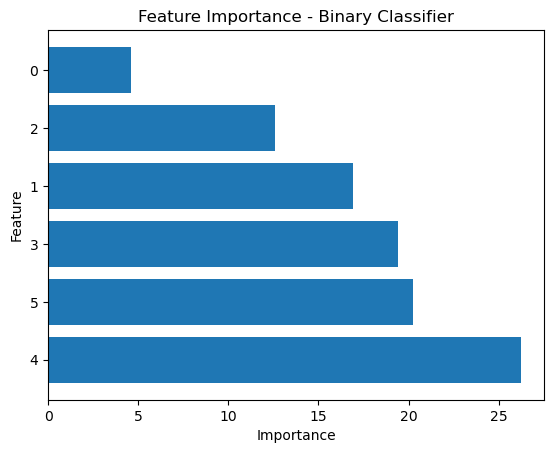

In [223]:
classifier_1_feature_importance = classifier_1.get_feature_importance(prettified=True)
plt.barh(classifier_1_feature_importance['Feature Id'], classifier_1_feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Binary Classifier')
plt.show()

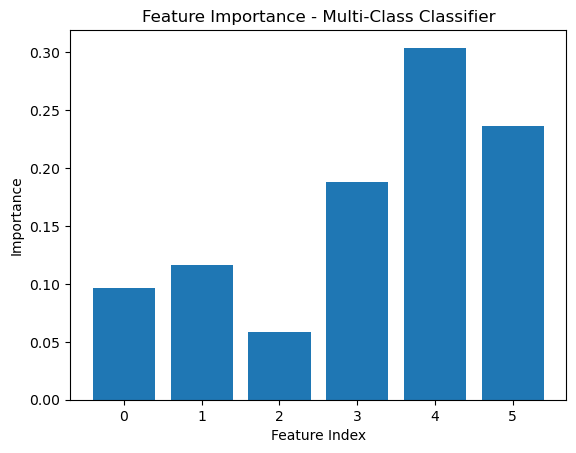

In [224]:
classifier_2_feature_importance = classifier_2.feature_importances_
plt.bar(range(len(classifier_2_feature_importance)), classifier_2_feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance - Multi-Class Classifier')
plt.show()

In [225]:
input_data = [[1, 298.4, 308.2, 1282, 60.7, 216]]  # Where 'M' = 0, 'L' = 1, 'H' = 2
input_scaled = sc.transform(input_data)

In [226]:
# Binary classification prediction (if failure occurs)
classifier_1_prediction = classifier_1.predict(input_scaled)

if classifier_1_prediction[0] == 1:  # If failure is predicted
    # Multi-class classification for failure type
    failure_type_prediction = classifier_2.predict(input_scaled)
    
    # Map integer to string failure type using the custom_mapping
    failure_type_value = failure_type_prediction[0]
    
    # Map the predicted value to a string using custom_mapping
    if failure_type_value in custom_mapping.values():
        # Reverse lookup of the custom_mapping to get the string (failure type)
        failure_type_string = [k for k, v in custom_mapping.items() if v == failure_type_value][0]
        print(f"Failure Predicted. Failure Type: {failure_type_string}")
    else:
        print(f"Error: Predicted value {failure_type_value} not in custom_mapping.")
else:
    print("No Failure")

Failure Predicted. Failure Type: Overstrain Failure
